<a href="https://colab.research.google.com/github/sorawit27/LSTM/blob/master/LSTM_Stock_Forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start by checking that all libraries are added and are of appropriate versions

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Now we import historical stock data from Yahoo Finance for three major banks in Thailand: Kasikorn Bank, Siam Commercial Bank, Bangkok Bank; the Airport of Thailand; S&P 500 Index; Microsoft; Apple; Amazon; and Alphabet

In [ ]:
!pip install pandas_datareader

from pandas_datareader import data as pdr
stock_names = ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','AAPL','AMZN','MSFT','GOOG']
stock_data = []

for name in stock_names:
    try:
        data = pd.DataFrame(pdr.get_data_yahoo(name, start='2005-01-01', end='2020-10-10'))
        stock_data.append(data)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

In [ ]:
stock_data[4].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-01-03,121.760002,119.900002,121.559998,120.300003,55748000.0,87.794243
2005-01-04,120.540001,118.440002,120.459999,118.830002,69167600.0,86.721436
2005-01-05,119.250000,118.000000,118.739998,118.010002,65667300.0,86.123009
2005-01-06,119.150002,118.260002,118.440002,118.610001,47814700.0,86.560890
2005-01-07,119.230003,118.129997,118.970001,118.440002,55847700.0,86.436821


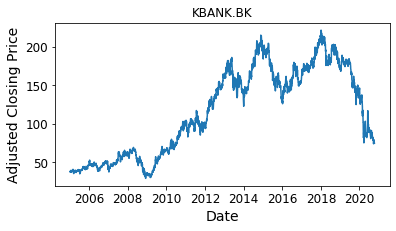

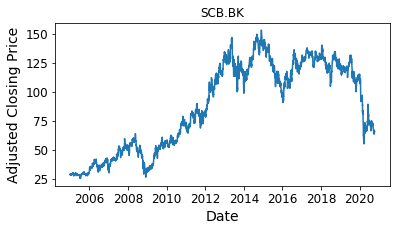

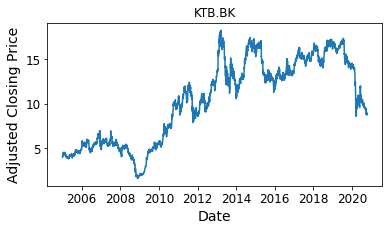

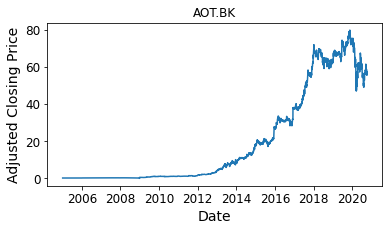

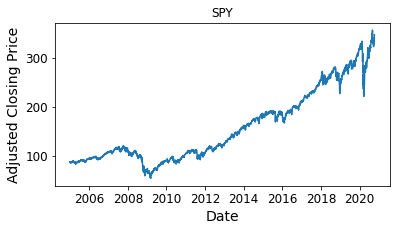

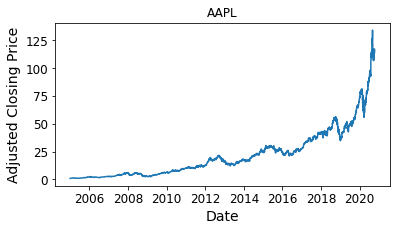

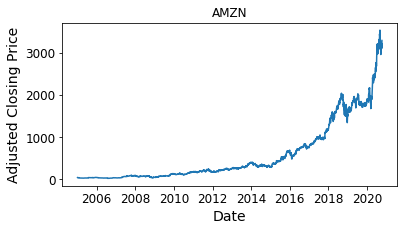

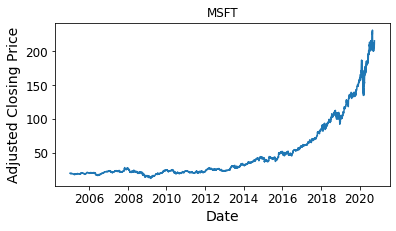

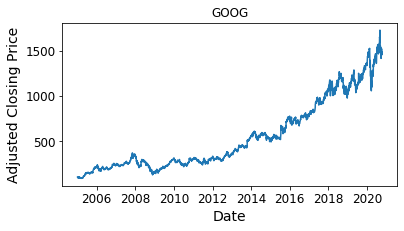

In [ ]:
# plot all stocks
i = 0
for stock in stock_data:
  plt.figure(figsize = (6,3))
  plt.plot(stock.index, stock["Adj Close"])
  plt.xlabel('Date')
  plt.ylabel('Adjusted Closing Price')
  plt.title(stock_names[i])
  i = i+1
  plt.show()

In [ ]:
len = (stock_data[4].shape)[0]
print(len)

3971


In [ ]:
# spit data into train/valid/test data (70/20/10)
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[4]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[4]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[4]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2779, 1)
(794, 1)
(398, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-60:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-60:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-60:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(2719, 60)
(2719,)
(734, 60)
(734,)
(338, 60)
(2719, 60, 1)
(2719,)
(734, 60, 1)
(734,)
(338, 60, 1)


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
# Adding LSTM layers with Dropout
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_valid, y_valid))

Epoch 1/100
85/85 [==============================] - 3s 30ms/step - loss: 0.0150 - val_loss: 0.0030
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 7/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 8/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 9/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 0.0020

In [ ]:
model.evaluate(X_valid, y_valid)

23/23 [==============================] - 0s 8ms/step - loss: 6.8751e-04


0.0006875087856315076

In [ ]:
dataset_total = stock_data[4]["Adj Close"]
inputs = dataset_total[stock_data[4].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)

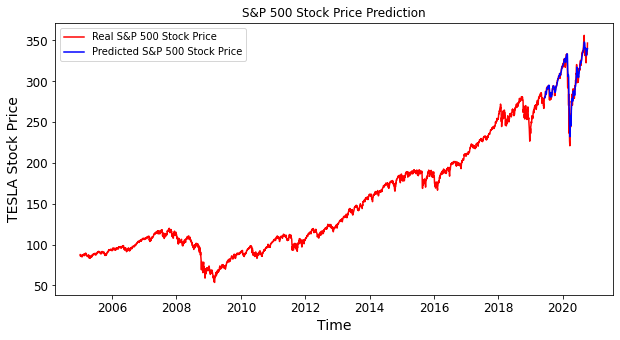

In [ ]:
# Visualising the results
plt.figure(figsize = (10,5))

plt.plot(stock_data[4].index, stock_data[4]['Adj Close'], color = "red", label = "Real S&P 500 Stock Price")
plt.plot(stock_data[4][valid_split+60:].index, y_test, color = "blue", label = "Predicted S&P 500 Stock Price")

plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()